<a href="https://colab.research.google.com/github/MikkelUlv13/TelecomX-Analisis-de-evasion-de-clientes-P2/blob/main/TelecomX_Analisis_de_evasion_de_clientes_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install pandas numpy scikit-learn matplotlib seaborn

# ====== IMPORTS ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set_theme()


# Extracción del Archivo Tratado

In [4]:
import pandas as pd
import requests

# URL de tu JSON en GitHub
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# Cargar datos JSON
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
    print("✅ JSON cargado correctamente")
else:
    print("❌ Error al acceder al JSON")

# Guardar como CSV
df.to_csv("TelecomX_Data.csv", index=False)
print("📁 Archivo guardado como TelecomX_Data.csv")

# Verificar primeras filas
df.head()


✅ JSON cargado correctamente
📁 Archivo guardado como TelecomX_Data.csv


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


### Eliminación de Columnas Irrelevantes

In [7]:
import pandas as pd

# Cargar JSON original
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
df = pd.read_json(url)

print("✅ Datos cargados:", df.shape)

# Revisamos las columnas
print("📋 Columnas del dataset:")
print(df.columns)

# Eliminamos columnas que no aportan valor (ejemplo: 'customerID')
cols_to_drop = ["customerID", "id", "phone", "email"]  # pon aquí las que detectes
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

print("🚮 Columnas eliminadas. Nuevo tamaño:", df.shape)

# Guardar en CSV
df.to_csv("telecomx_clean.csv", index=False)
print("💾 Archivo guardado como telecomx_clean.csv")


✅ Datos cargados: (7267, 6)
📋 Columnas del dataset:
Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')
🚮 Columnas eliminadas. Nuevo tamaño: (7267, 4)
💾 Archivo guardado como telecomx_clean.csv


In [9]:
df.columns

Index(['Churn', 'customer', 'internet', 'account'], dtype='object')

Se hace una normalización de nuevo para tener listo el CSV removiendo la columna costumer ID

In [10]:
from pandas import json_normalize
import pandas as pd

# Cargar JSON desde la URL
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
df = pd.read_json(url)

# Aplanar las columnas anidadas
df_flat = pd.json_normalize(
    df.to_dict(orient="records"), sep="_"
)

print("✅ Datos aplanados:", df_flat.shape)
print("📋 Nuevas columnas:")
print(df_flat.columns)

# Eliminar columnas que no sirven para predicción
cols_to_drop = ["customer_customerID"]  # identificador único
df_flat = df_flat.drop(columns=[col for col in cols_to_drop if col in df_flat.columns])

# Guardar como CSV limpio
df_flat.to_csv("telecomx_clean.csv", index=False)
print("💾 Archivo exportado: telecomx_clean.csv")


✅ Datos aplanados: (7267, 21)
📋 Nuevas columnas:
Index(['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges_Monthly', 'account_Charges_Total'],
      dtype='object')
💾 Archivo exportado: telecomx_clean.csv


In [12]:
# Descargarlo como CSV
from google.colab import files
files.download("telecomx_clean.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Encoding

#### Dos métodos principales para One-Hot Encoding:
1. pd.get_dummies() (rápido y sencillo en Pandas)

Convierte cada categoría en una columna binaria (0 o 1).
✅ Ventaja: muy rápido y directo.
⚠️ Desventaja: puede generar demasiadas columnas si hay muchas categorías.


2. OneHotEncoder de scikit-learn (más flexible y profesional)

Útil cuando vas a entrenar un modelo en sklearn porque devuelve una matriz optimizada.
✅ Ventaja: se integra con pipelines de machine learning.
⚠️ Desventaja: un poco más de código, no tan directo como get_dummies.

#### A) Encoding con pandas.get_dummies() (rápido para EDA / CSV)

In [16]:
# Subir archivo desde tu computadora
from google.colab import files
import pandas as pd

# Esto abre un diálogo para elegir el archivo en tu compu
uploaded = files.upload()

# Cargar el CSV en un DataFrame
df = pd.read_csv("telecomx_clean.csv")

# Ver las primeras filas
df.head()



Saving telecomx_clean.csv to telecomx_clean (1).csv


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


##### 🔹 Método 1 – get_dummies (rápido y sencillo)

In [17]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("telecomx_clean.csv")

# Ver columnas categóricas
print(df.select_dtypes(include=['object']).columns)

# One-hot encoding con pandas
df_encoded = pd.get_dummies(df, drop_first=True)

print(df_encoded.head())


Index(['customerID', 'Churn', 'customer_gender', 'customer_Partner',
       'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines',
       'internet_InternetService', 'internet_OnlineSecurity',
       'internet_OnlineBackup', 'internet_DeviceProtection',
       'internet_TechSupport', 'internet_StreamingTV',
       'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges_Total'],
      dtype='object')
   customer_SeniorCitizen  customer_tenure  account_Charges_Monthly  \
0                       0                9                     65.6   
1                       0                9                     59.9   
2                       0                4                     73.9   
3                       1               13                     98.0   
4                       1                3                     83.9   

   customerID_0003-MKNFE  customerID_0004-TLHLJ  customerID_0011-IGKFF  \
0      

##### 🔹 Método 2 – OneHotEncoder (más flexible, sklearn)

In [18]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Cargar dataset
df = pd.read_csv("telecomx_clean.csv")

# Seleccionar columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns

# Crear el encoder
encoder = OneHotEncoder(drop="first", sparse_output=False)

# Aplicar encoding
encoded_array = encoder.fit_transform(df[cat_cols])

# Convertir a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols))

# Concatenar con las columnas numéricas
df_final = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

print(df_final.head())


   customer_SeniorCitizen  customer_tenure  account_Charges_Monthly  \
0                       0                9                     65.6   
1                       0                9                     59.9   
2                       0                4                     73.9   
3                       1               13                     98.0   
4                       1                3                     83.9   

   customerID_0003-MKNFE  customerID_0004-TLHLJ  customerID_0011-IGKFF  \
0                    0.0                    0.0                    0.0   
1                    1.0                    0.0                    0.0   
2                    0.0                    1.0                    0.0   
3                    0.0                    0.0                    1.0   
4                    0.0                    0.0                    0.0   

   customerID_0013-EXCHZ  customerID_0013-MHZWF  customerID_0013-SMEOE  \
0                    0.0                    0.0       

### Verificación de la Proporción de Cancelación (Churn)

In [19]:
# 1. Importar librerías
import pandas as pd

# 2. Cargar el archivo CSV
df = pd.read_csv("telecomx_clean.csv")

# 3. Revisar las primeras filas para confirmar la estructura
print(df.head())

# 4. Calcular la proporción de cancelación
# Suponiendo que la columna se llama "Churn" y contiene valores como "Yes/No" o 1/0
print("\nConteo de clases:")
print(df['Churn'].value_counts())

print("\nProporción de clases:")
print(df['Churn'].value_counts(normalize=True))


   customerID Churn customer_gender  customer_SeniorCitizen customer_Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer_Dependents  customer_tenure phone_PhoneService phone_MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  internet_InternetService  ... 

### Balanceo de Clases

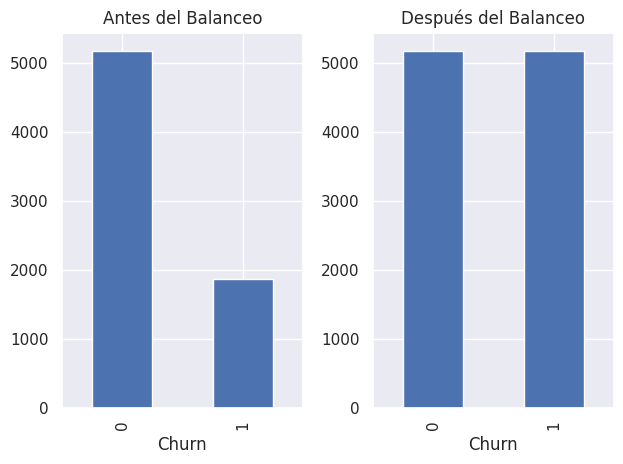

In [64]:
import matplotlib.pyplot as plt

# Graficar el antes
plt.subplot(1, 2, 1)
y.value_counts().plot(kind="bar", title="Antes del Balanceo")

# Graficar el después
plt.subplot(1, 2, 2)
pd.Series(y_resampled).value_counts().plot(kind="bar", title="Después del Balanceo")

plt.tight_layout()
plt.show()


In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# ------- 1) Cargar -------
df = pd.read_csv("telecomx_clean.csv").copy()

print("Valores en Churn (antes):")
print(df["Churn"].value_counts(dropna=False))

# ------- 2) Normalizar Churn (robusto: texto/bool/num -> 0/1; NaN se conserva) -------
def normalize_churn_series(s: pd.Series) -> pd.Series:
    def norm(v):
        if pd.isna(v):                # NaN se queda NaN
            return np.nan
        if isinstance(v, (int, np.integer)):
            return 1 if v == 1 else 0
        if isinstance(v, bool):
            return int(v)
        if isinstance(v, str):
            t = v.strip().lower()
            if t in ("yes", "si", "sí", "true", "1"):
                return 1
            if t in ("no", "false", "0"):
                return 0
        # cualquier cosa rara -> NaN
        return np.nan
    return s.apply(norm)

df["Churn"] = normalize_churn_series(df["Churn"])

# eliminar filas sin etiqueta
na_rows = int(df["Churn"].isna().sum())
if na_rows:
    print(f"⚠️ Eliminando {na_rows} filas sin etiqueta Churn.")
    df = df.dropna(subset=["Churn"]).copy()

df["Churn"] = df["Churn"].astype(int)

print("\nDistribución ya normalizada:")
print(df["Churn"].value_counts(normalize=True).round(3))
print(df["Churn"].value_counts())

# ------- 3) Split (el balanceo SIEMPRE solo en train) -------
X = df.drop(columns=["Churn"])
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train = X_train.copy()
train["Churn"] = y_train.values

# ------- 4a) Undersampling -------
maj = train[train["Churn"] == 0]
min_ = train[train["Churn"] == 1]

if len(min_) == 0:
    raise ValueError("La clase minoritaria tiene 0 registros. Revisa los valores de Churn.")

maj_down = resample(maj, replace=False, n_samples=len(min_), random_state=42)
train_under = pd.concat([maj_down, min_]).sample(frac=1, random_state=42)
print("\nUndersampling (train):\n", train_under["Churn"].value_counts())

# ------- 4b) Oversampling -------
min_up = resample(min_, replace=True, n_samples=len(maj), random_state=42)
train_over = pd.concat([maj, min_up]).sample(frac=1, random_state=42)
print("\nOversampling (train):\n", train_over["Churn"].value_counts())

# ------- 4c) SMOTE (One-Hot previo para categóricas) -------
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

pre = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
)
Xtr_num = pre.fit_transform(X_train)
sm = SMOTE(random_state=42)
Xtr_smote, ytr_smote = sm.fit_resample(Xtr_num, y_train)

print("\nSMOTE (train): 0 ->", int((ytr_smote==0).sum()), " | 1 ->", int((ytr_smote==1).sum()))


Valores en Churn (antes):
Churn
No     5174
Yes    1869
NaN     224
Name: count, dtype: int64
⚠️ Eliminando 224 filas sin etiqueta Churn.

Distribución ya normalizada:
Churn
0    0.735
1    0.265
Name: proportion, dtype: float64
Churn
0    5174
1    1869
Name: count, dtype: int64

Undersampling (train):
 Churn
0    1495
1    1495
Name: count, dtype: int64

Oversampling (train):
 Churn
0    4139
1    4139
Name: count, dtype: int64

SMOTE (train): 0 -> 4139  | 1 -> 4139


### Normalización o Estandarización

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 1️⃣ Separar variables predictoras (X) y objetivo (y)
X = df.drop("Churn", axis=1)
y = df["Churn"]

# 2️⃣ Dividir en numéricas y categóricas
X_num = X.select_dtypes(include=["int64", "float64"])
X_cat = X.select_dtypes(include=["object"])

print("Columnas numéricas:", list(X_num.columns))
print("Columnas categóricas:", list(X_cat.columns))

# 3️⃣ Codificar categóricas con One-Hot Encoding
X_cat_encoded = pd.get_dummies(X_cat, drop_first=True)

# 4️⃣ Concatenar numéricas y categóricas ya codificadas
X_ready = pd.concat([X_num, X_cat_encoded], axis=1)

# 5️⃣ Normalización (0–1)
scaler_minmax = MinMaxScaler()
X_normalizado = scaler_minmax.fit_transform(X_ready)
X_normalizado = pd.DataFrame(X_normalizado, columns=X_ready.columns)

# 6️⃣ Estandarización (media=0, std=1)
scaler_standard = StandardScaler()
X_estandarizado = scaler_standard.fit_transform(X_ready)
X_estandarizado = pd.DataFrame(X_estandarizado, columns=X_ready.columns)

# 7️⃣ Unir con variable objetivo
df_normalizado = pd.concat([X_normalizado, y.reset_index(drop=True)], axis=1)
df_estandarizado = pd.concat([X_estandarizado, y.reset_index(drop=True)], axis=1)

print("✅ DataFrames listos:")
print("- df_normalizado (0–1)")
print("- df_estandarizado (media=0, std=1)")



Columnas numéricas: ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges_Monthly']
Columnas categóricas: ['customerID', 'customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges_Total']
✅ DataFrames listos:
- df_normalizado (0–1)
- df_estandarizado (media=0, std=1)


# Correlación y Selección de Variables

### Análisis de Correlación

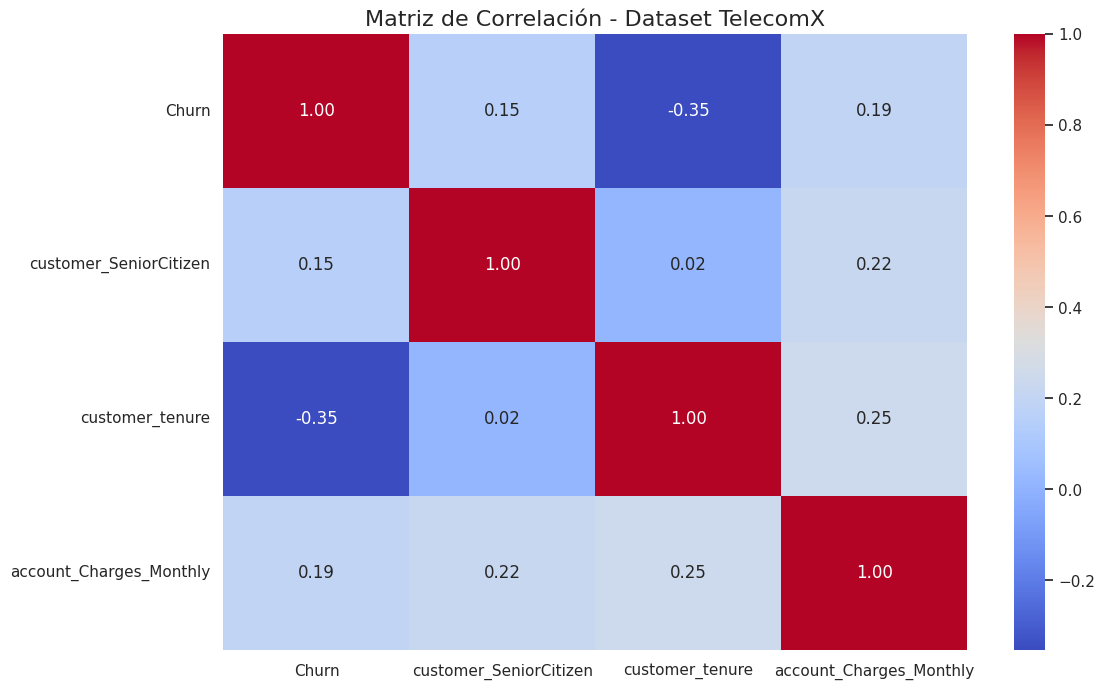

,Churn,customer_SeniorCitizen,customer_tenure,account_Charges_Monthly
Churn,1.000000,0.150889,-0.352229,0.193356
customer_SeniorCitizen,0.150889,1.000000,0.016567,0.220173
customer_tenure,-0.352229,0.016567,1.000000,0.247900
account_Charges_Monthly,0.193356,0.220173,0.247900,1.000000


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de correlación solo para variables numéricas
corr_matrix = df.corr(numeric_only=True)

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación - Dataset TelecomX", fontsize=16)
plt.show()

corr_matrix


#### Análisis Dirigido

In [30]:
print(df.columns)

Index(['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges_Monthly', 'account_Charges_Total'],
      dtype='object')


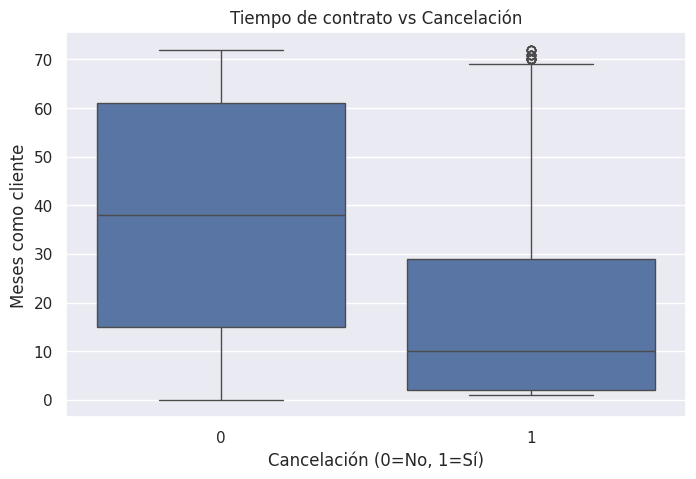

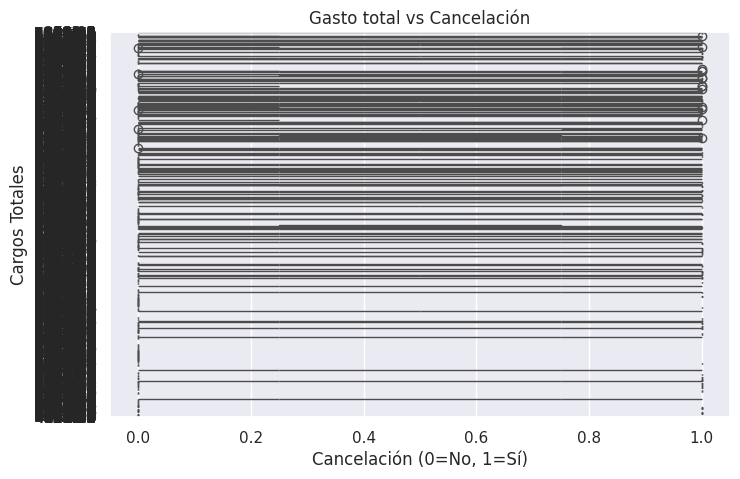

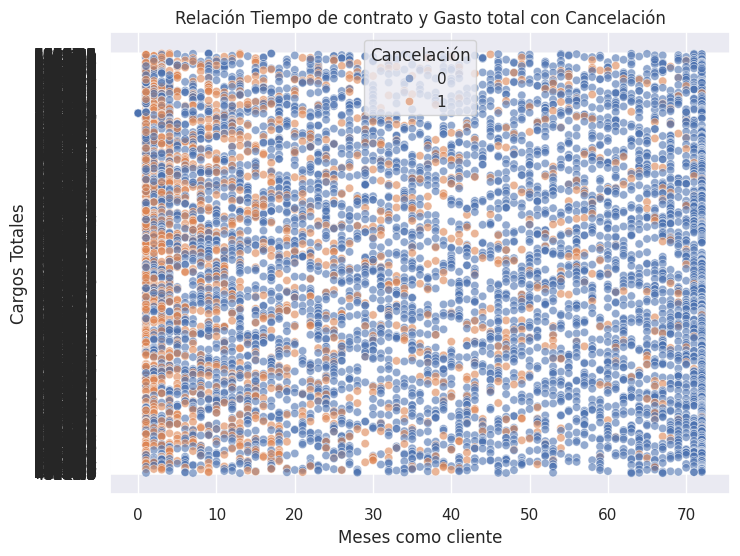

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot: Tiempo de contrato vs Cancelación
plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="customer_tenure", data=df)
plt.title("Tiempo de contrato vs Cancelación")
plt.xlabel("Cancelación (0=No, 1=Sí)")
plt.ylabel("Meses como cliente")
plt.show()

# Boxplot: Gasto total vs Cancelación
plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="account_Charges_Total", data=df)
plt.title("Gasto total vs Cancelación")
plt.xlabel("Cancelación (0=No, 1=Sí)")
plt.ylabel("Cargos Totales")
plt.show()

# Scatterplot: Tiempo de contrato vs Gasto total coloreado por Cancelación
plt.figure(figsize=(8,6))
sns.scatterplot(x="customer_tenure", y="account_Charges_Total", hue="Churn", data=df, alpha=0.6)
plt.title("Relación Tiempo de contrato y Gasto total con Cancelación")
plt.xlabel("Meses como cliente")
plt.ylabel("Cargos Totales")
plt.legend(title="Cancelación")
plt.show()


# Modelado predictivo

### Separación de Datos

In [34]:
# Definir variables predictoras (X) y variable objetivo (y)
X = df.drop("Churn", axis=1)   # 'Churn' es la columna target en tu dataset
y = df["Churn"]

X.head(), y.head()


(   customerID customer_gender  customer_SeniorCitizen customer_Partner  \
 0  0002-ORFBO          Female                       0              Yes   
 1  0003-MKNFE            Male                       0               No   
 2  0004-TLHLJ            Male                       0               No   
 3  0011-IGKFF            Male                       1              Yes   
 4  0013-EXCHZ          Female                       1              Yes   
 
   customer_Dependents  customer_tenure phone_PhoneService phone_MultipleLines  \
 0                 Yes                9                Yes                  No   
 1                  No                9                Yes                 Yes   
 2                  No                4                Yes                  No   
 3                  No               13                Yes                  No   
 4                  No                3                Yes                  No   
 
   internet_InternetService internet_OnlineSecurity in

In [35]:
# Convertir target a binario
y = y.map({"Yes": 1, "No": 0})


In [37]:
from sklearn.model_selection import train_test_split

# Definir variables predictoras (X) y variable objetivo (y)
X = df.drop(columns=['Churn', 'customerID'])  # quitamos la variable target y el ID
y = df['Churn']

# Dividir en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,   # 30% para prueba
    random_state=42, # semilla para reproducibilidad
    stratify=y       # mantiene la proporción de clases de 'Churn'
)

print("Tamaño del set de entrenamiento:", X_train.shape)
print("Tamaño del set de prueba:", X_test.shape)


Tamaño del set de entrenamiento: (4930, 19)
Tamaño del set de prueba: (2113, 19)


### Creación de Modelos

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ==========================
# 1. Separar X e y
# ==========================
X = df.drop("Churn", axis=1)  # variables predictoras
y = df["Churn"]               # variable target (0 o 1)

# ==========================
# 2. Detectar columnas categóricas y numéricas
# ==========================
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

print("Categóricas:", list(cat_cols))
print("Numéricas:", list(num_cols))

# ==========================
# 3. Preprocesador (OneHot para categóricas, passthrough para numéricas)
# ==========================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# ==========================
# 4. Split train/test
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==========================
# 5. Modelo 1: Regresión Logística
# ==========================
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("📊 Logistic Regression")
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

# ==========================
# 6. Modelo 2: Random Forest
# ==========================
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n🌲 Random Forest")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Categóricas: ['customerID', 'customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges_Total']
Numéricas: ['customer_SeniorCitizen', 'customer_tenure', 'account_Charges_Monthly']
📊 Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1552
           1       0.64      0.55      0.59       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113

Accuracy: 0.7988641741599621

🌲 Random Forest
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     

In [45]:
X_train.dtypes

,0
customerID,object
customer_gender,object
customer_SeniorCitizen,int64
customer_Partner,object
customer_Dependents,object
customer_tenure,int64
phone_PhoneService,object
phone_MultipleLines,object
internet_InternetService,object
internet_OnlineSecurity,object


In [49]:
y.isna().sum()


np.int64(0)

In [51]:
# Ver cuántos valores nulos hay en y
print(y.isna().sum())

# Mostrar las filas que tienen NaN en y
print(y[y.isna()])


7043
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
7262   NaN
7263   NaN
7264   NaN
7265   NaN
7266   NaN
Name: Churn, Length: 7043, dtype: float64


In [52]:
# Asegurar que los valores estén limpios (sin espacios y en minúsculas)
df["Churn"] = df["Churn"].astype(str).str.strip().str.lower()

# Mapear a binario
y = df["Churn"].map({"yes": 1, "no": 0})

# Revisar que no haya NaN
print("Valores nulos en y:", y.isna().sum())
print(y.value_counts())


Valores nulos en y: 7043
Series([], Name: count, dtype: int64)


In [53]:
print(df["Churn"].unique())

['0' '1']


In [58]:
df["Churn"] = df["Churn"].astype(int)

In [55]:
print(df["Churn"].unique())

[0 1]


<Axes: xlabel='Churn'>

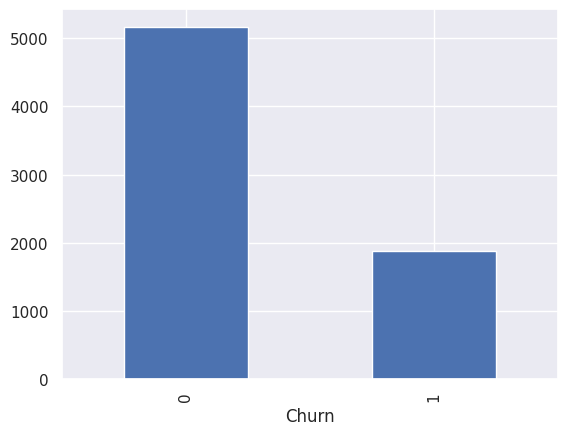

In [59]:
df["Churn"].value_counts()
df["Churn"].value_counts().plot(kind="bar")

In [61]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

# Codificar variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

print("Antes del balanceo:", Counter(y))
print("Después del balanceo:", Counter(y_resampled))


Antes del balanceo: Counter({0: 5174, 1: 1869})
Después del balanceo: Counter({0: 5174, 1: 5174})


<Axes: xlabel='Churn'>

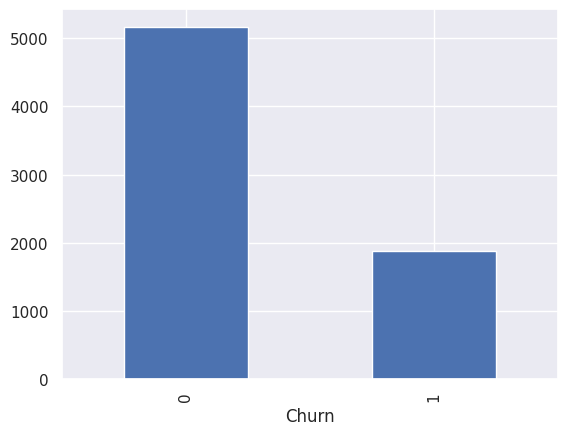

In [62]:
df["Churn"].value_counts()
df["Churn"].value_counts().plot(kind="bar")

# Ahora si, pasar a la creación de modelos

In [67]:
print(y.isnull().sum())
print(y.unique())


224
[ 0.  1. nan]


In [71]:
X = X[~y.isnull()]
y = y[~y.isnull()]

In [72]:
assert y.isnull().sum() == 0, "El target contiene NaN"

In [73]:
# Balanceo con SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Antes del balanceo:", Counter(y))
print("Después del balanceo:", Counter(y_res))


Antes del balanceo: Counter({0.0: 5174, 1.0: 1869})
Después del balanceo: Counter({0.0: 5174, 1.0: 5174})


In [77]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Cargar el dataset original
data = pd.read_csv("telecomx_clean.csv")  # pon aquí el nombre real del archivo

# Separar variables independientes y dependiente
X = data.drop("target", axis=1)  # reemplaza "target" por tu variable objetivo
y = data["target"]

# Aplicar SMOTE para balancear
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Unir de nuevo en un DataFrame balanceado
data_balanceado = pd.concat([pd.DataFrame(X_res, columns=X.columns),
                             pd.DataFrame(y_res, columns=["target"])], axis=1)

# Exportar dataset balanceado
data_balanceado.to_csv("telecomx_clean.csv", index=False)

print("✅ Dataset balanceado exportado como 'dataset_balanceado.csv'")


KeyError: "['target'] not found in axis"

### Modelo de Regresión Logística

In [74]:
# ================================
# MODELO 1: REGRESIÓN LOGÍSTICA
# ================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- Carga el dataset balanceado ---
df_balanceado = pd.read_csv("datos_balanceados.csv")  # 👈 pon aquí tu archivo balanceado

# --- Definir variables independientes y dependiente ---
X = df_balanceado.drop("target", axis=1)  # 👈 cambia "target" por el nombre de tu variable objetivo
y = df_balanceado["target"]

# --- Dividir en entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Normalizar datos ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Entrenar modelo ---
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# --- Predicciones ---
y_pred = log_reg.predict(X_test_scaled)

# --- Evaluación ---
print("🔹 MATRIZ DE CONFUSIÓN (Regresión Logística)")
print(confusion_matrix(y_test, y_pred))

print("\n🔹 REPORTE DE CLASIFICACIÓN (Regresión Logística)")
print(classification_report(y_test, y_pred))


FileNotFoundError: [Errno 2] No such file or directory: 'datos_balanceados.csv'